In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn
import warnings
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.stats import norm, skew #for some statistics

### Loading Data

In [33]:
#Carga de datos de propiedades
train = pd.read_csv('train_home.csv')
labels=train["SalePrice"]
test = pd.read_csv('test_home.csv')
data = pd.concat([train,test],ignore_index=True)
data = data.drop("SalePrice", 1)
test_ids = test['Id']

In [34]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [35]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Data dimension: Test and Train

In [36]:
print("Train Shape:", train.shape)
print("Train Duplicated data :", train.duplicated().sum())

Train Shape: (1460, 81)
Train Duplicated data : 0


In [37]:
print("Train Shape:", test.shape)
print("Train Duplicated data :", test.duplicated().sum())

Train Shape: (1459, 80)
Train Duplicated data : 0


### Predict variable distribution

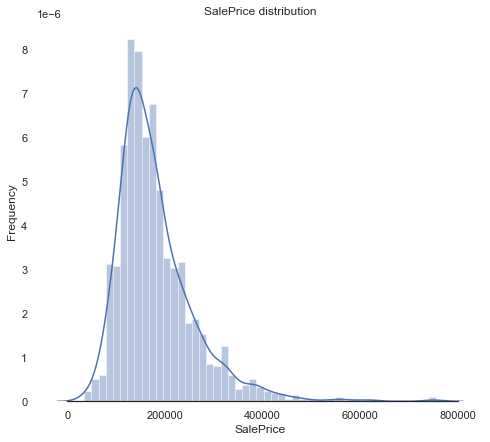

In [38]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Seaborn plot for distribution in the predict variable
sns.distplot(train['SalePrice'], color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

### Kurtosis and Skewness

In [39]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Missing Values with missigno library

<AxesSubplot:>

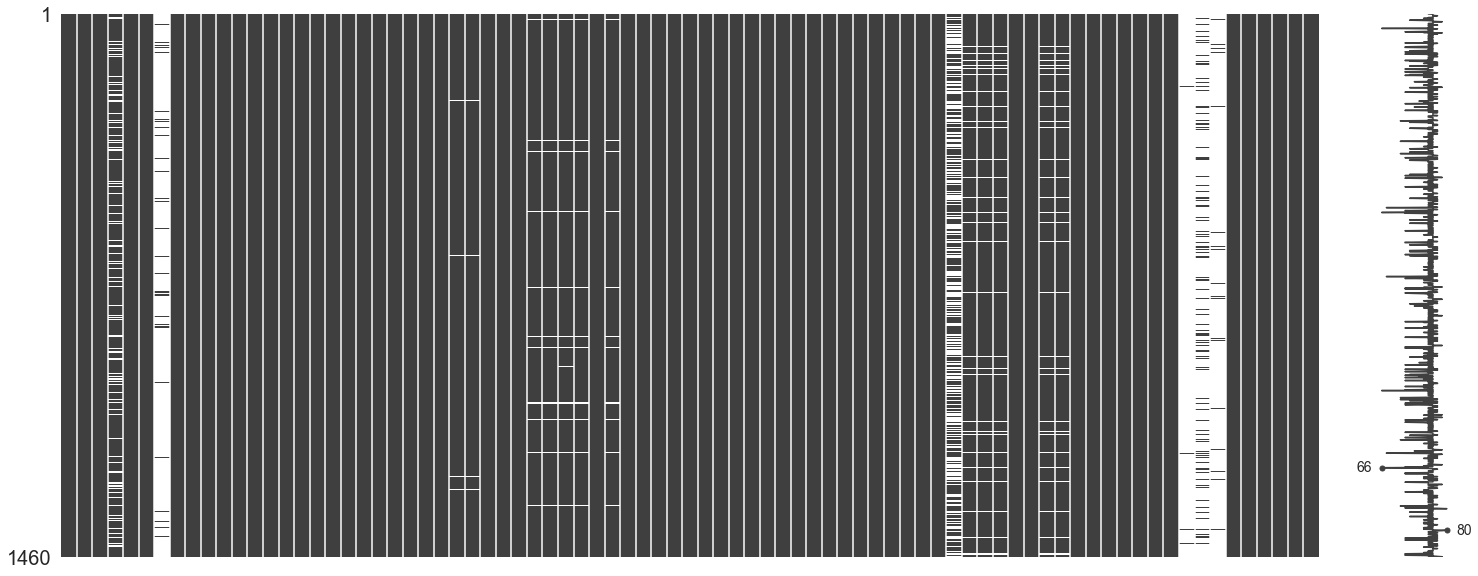

In [40]:
msno.matrix(train)

### Relationship between numerical variables: Bivariate Analysis

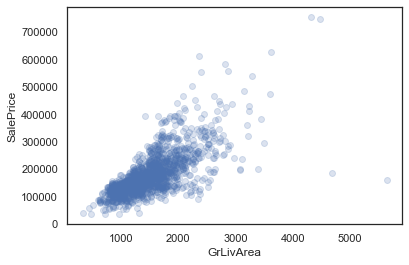

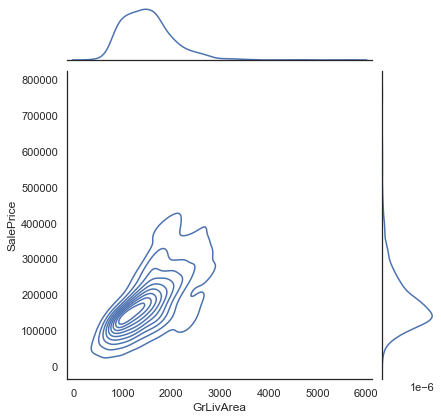

In [41]:
x = 'GrLivArea'
y = 'SalePrice'
sns.regplot(x = x, y=y, data=train, fit_reg = False, scatter_kws={"alpha": 0.2})
sns.jointplot(x = x, y=y, data=train, kind = 'kde')

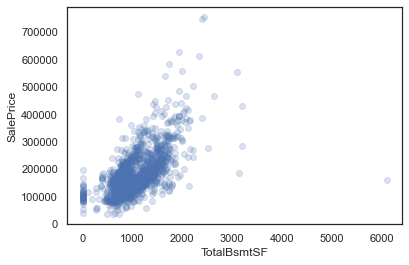

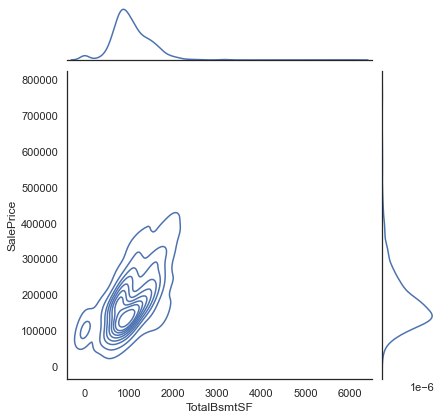

In [42]:
x = 'TotalBsmtSF'
y = 'SalePrice'
sns.regplot(x = x, y=y, data=train, fit_reg = False, scatter_kws={"alpha": 0.2})
sns.jointplot(x = x, y=y, data=train, kind = 'kde')

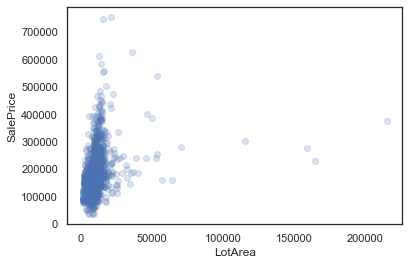

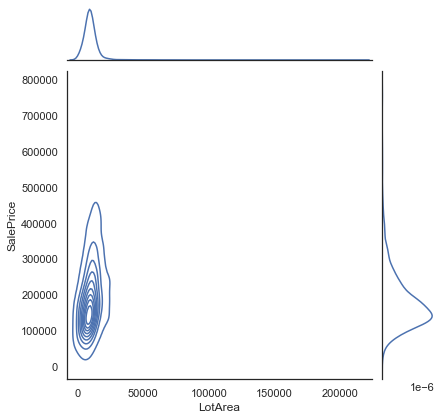

In [43]:
x = 'LotArea'
y = 'SalePrice'
sns.regplot(x = x, y=y, data=train, fit_reg = False, scatter_kws={"alpha": 0.2})
sns.jointplot(x = x, y=y, data=train, kind = 'kde')

### Relationship between categorical variables: Boxplot

(-0.5, 9.5, 0.0, 800000.0)

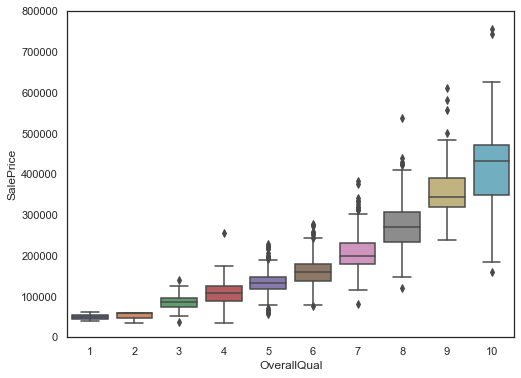

In [44]:
#Categorical variables
x = 'OverallQual'
data = pd.concat([train['SalePrice'], train[x]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=x, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0, '1910'),
  Text(15, 0, '1911'),
  Text(1

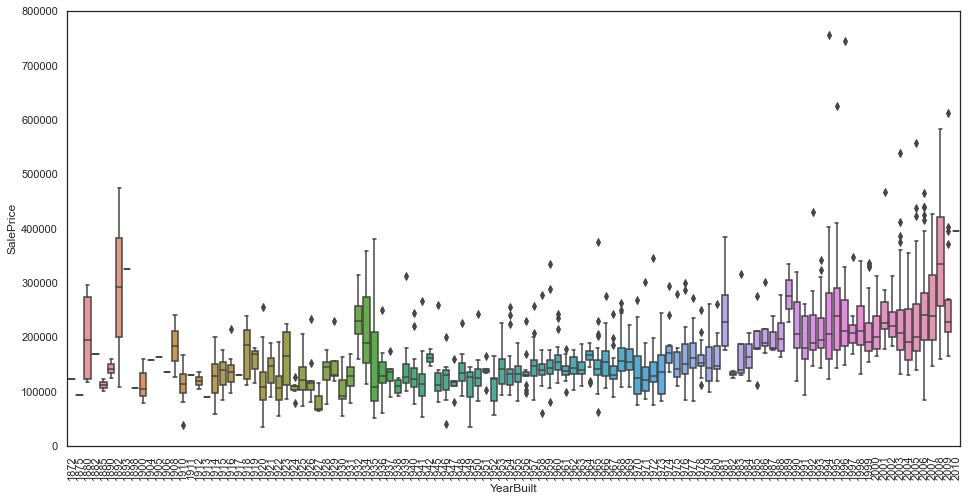

In [45]:
x = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[x]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=x, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

### Correlation Analysis

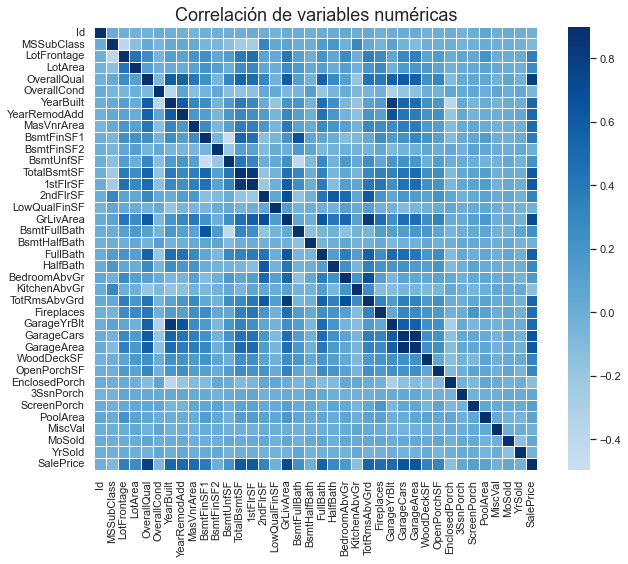

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(),
            #annot=True,
            vmax=0.9,
            linewidths=.5,
            center=0,
            #cbar=False,
            square=True,
            cmap="Blues"
            )
plt.title('Correlación de variables numéricas', fontsize=18)
plt.tight_layout()
plt.show()

### Pairplot to study the relationship between numerical variables and its distribution

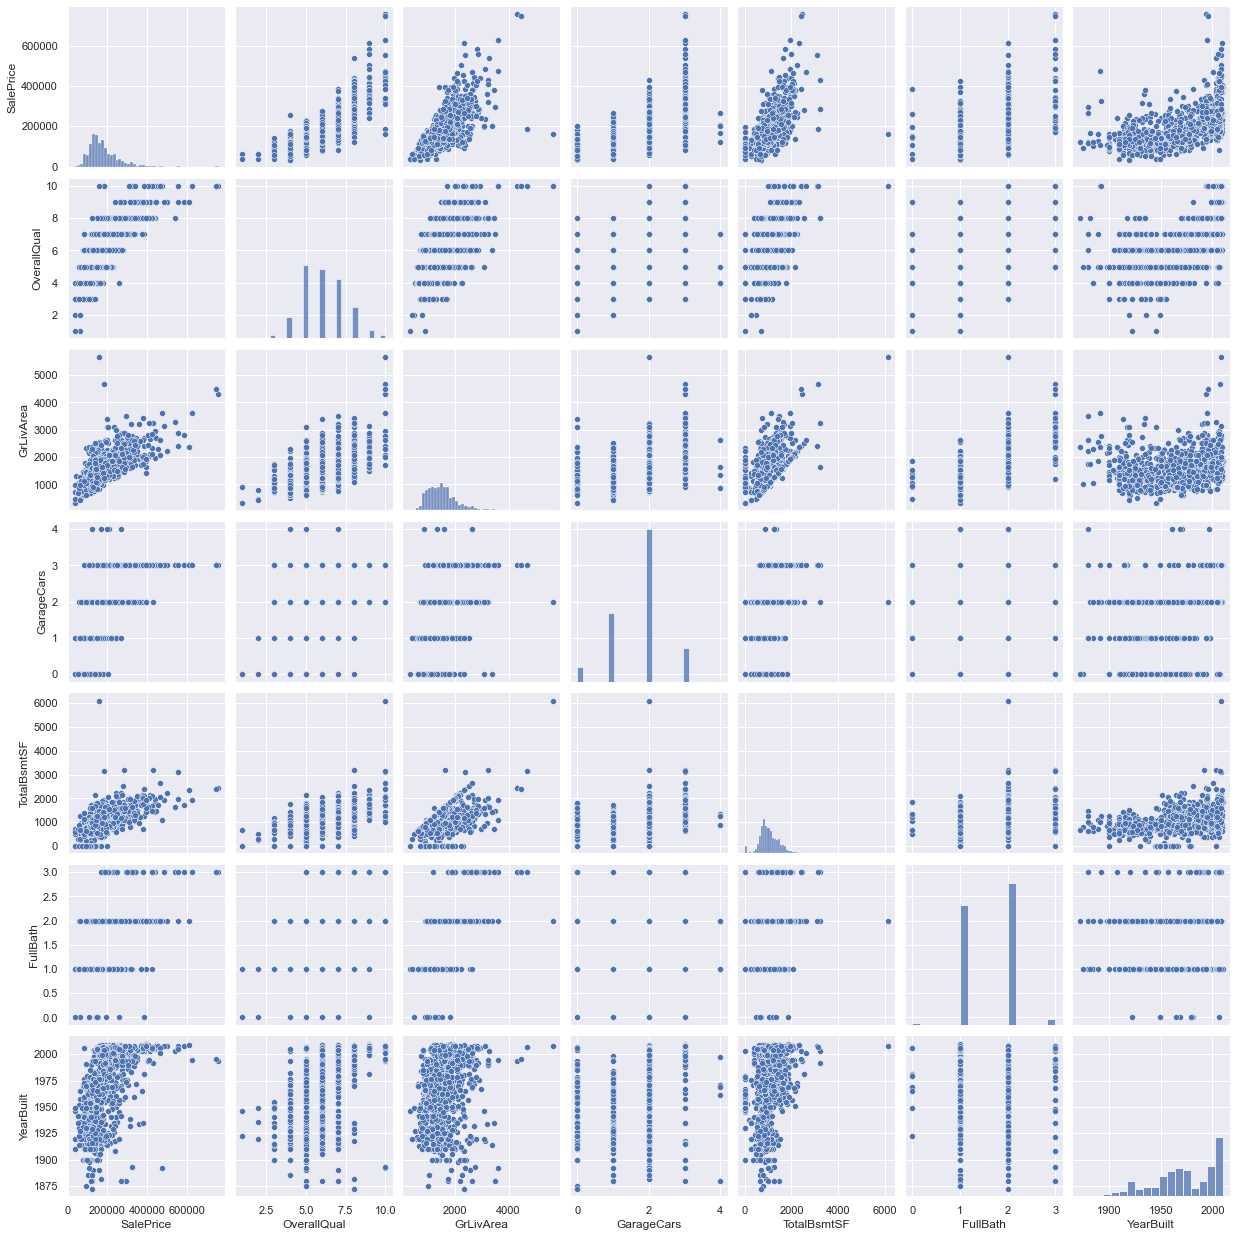

In [49]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

#### Now we study the outliers and the numerical variables, we can get the numerical variables with the get_numeric_data() method and then analyse the columns with horizontal boxplots

In [50]:
num_cols = train._get_numeric_data().columns
num_cols

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [52]:
new_data = train._get_numeric_data().copy()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
new_data2 = new_data[cols]
new_data2.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,208500,7,1710,2,856,2,2003
1,181500,6,1262,2,1262,2,1976
2,223500,7,1786,2,920,2,2001
3,140000,7,1717,3,756,1,1915
4,250000,8,2198,3,1145,2,2000


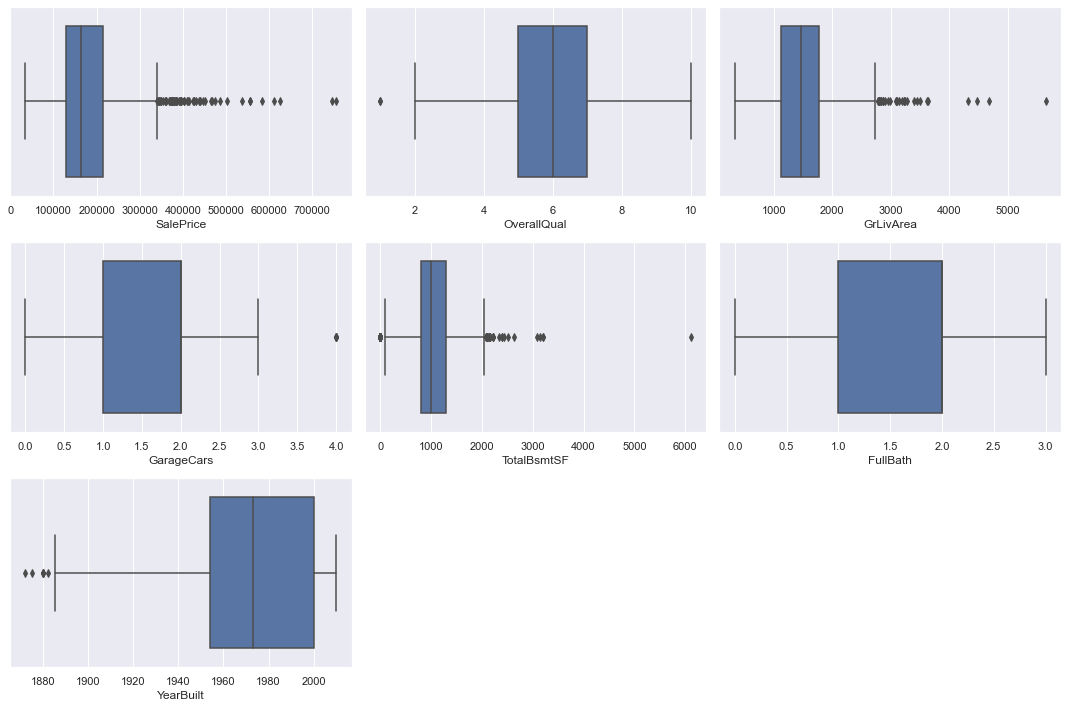

In [53]:
plt.figure(figsize=(15, 10))
pos = 1
for i in new_data2.columns:
    plt.subplot(3, 3, pos)
    sns.boxplot(x=new_data2[i])
    pos += 1
plt.tight_layout()
plt.show()

### Feature Engineering

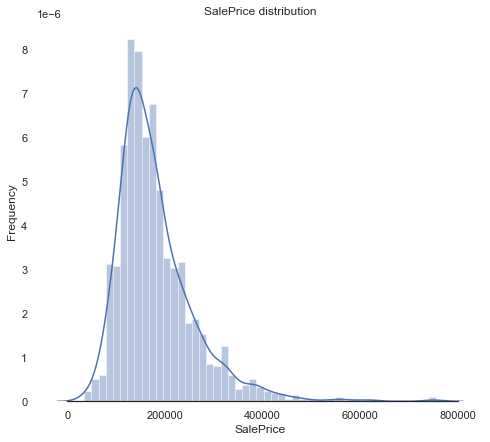

In [54]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Seaborn plot for distribution in the predict variable
sns.distplot(train['SalePrice'], color="b")
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()


 mu = 12.02 and sigma = 0.40



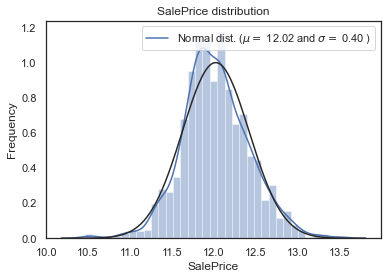

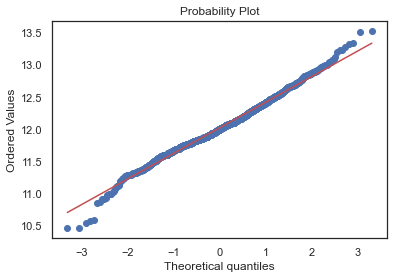

In [55]:
#LOG(1+x) for predict label
train["SalePrice"] = np.log1p(train["SalePrice"])
#New distribution
sns.distplot(train['SalePrice'] , fit=norm);
#Fitted parameters
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Plot the distribution over fitting parameters
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [66]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


In [67]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071
GarageYrBlt,5.447071


In [68]:
#Missing values count second form
nans=pd.isnull(all_data).sum().sort_values(ascending=False)
nans[nans>0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
GarageCars         1
KitchenQual        1
BsmtFinSF1         1
SaleType           1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
GarageArea         1
Electrical         1
dtype: int64

Text(0.5, 1.0, 'Percent missing data by feature')

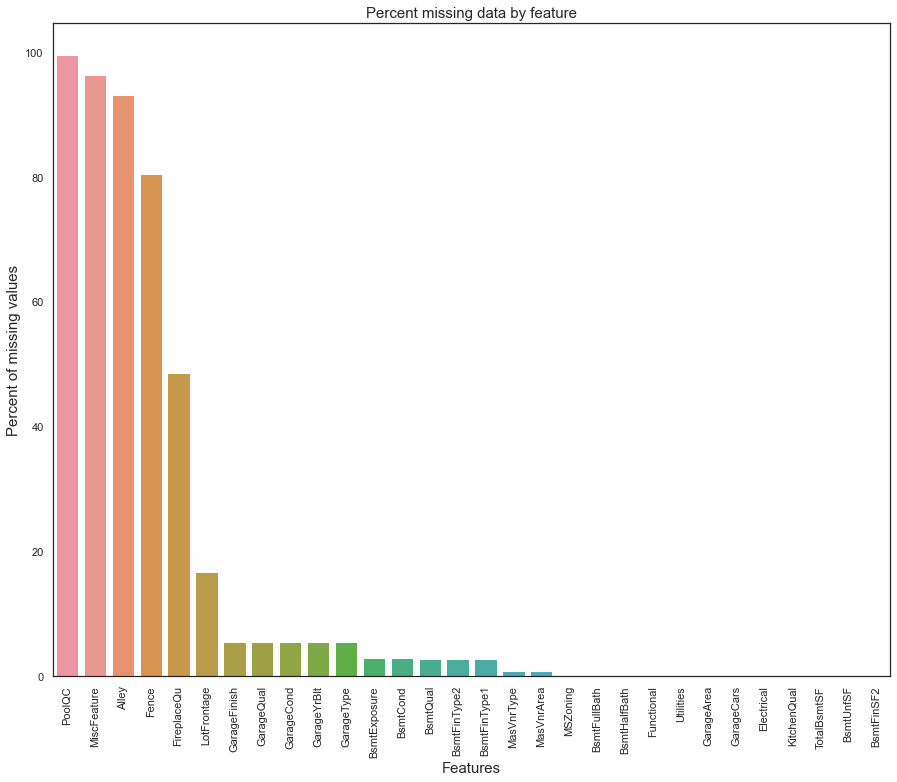

In [69]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [70]:
#conteo de tipos de columnas
all_data.dtypes.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [81]:
cols_none = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','MSSubClass']
cols_zero = ['GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea']
cols_mode = ['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']

### Missing Values treatment

In [82]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in cols_none:
    all_data[col] = all_data[col].fillna('None')
for col in cols_zero:
    all_data[col] = all_data[col].fillna(0)
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [83]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [ ]:
#Convert categorical variables
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [84]:
from sklearn.preprocessing import LabelEncoder
cols_categorical = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
                    'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
                    'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
                    'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
                    'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols_categorical:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 79)


In [85]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### Analysis over numerical features